# EDA for Used Car Data

<div class="alert alert-block alert-info">
    
### Source Dataset :  

9337 used car listings scraped from a car website and augmented with additional data.
Please refer to the file UsedCarDataPreparation for details on the data synthesis

### EDA Objectives: 

1. Describe basic statistical data of the dataset
2. Explore data quality - Variances, Outliers, Distributions, Skewness
3. Perform label encoding and explore relationships
4. Execute initial basic model and explore results.

</div>



In [1]:
# Libraries for data processing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option('display.max_colwidth',0)
pd.set_option('display.float_format',lambda x: '%.2f' %x)
pd.set_option('display.max_rows',300)
pd.set_option('display.max_columns',0)
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import missingno as msno
import itertools
import math
from datetime import datetime


In [2]:
# Libraries for modeling and encoding
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR
from xgboost import XGBRegressor,plot_importance
from sklearn.metrics import mean_absolute_error,roc_curve, auc,mean_squared_error,make_scorer,classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from scipy.stats import uniform, truncnorm, randint
from mlxtend.regressor import StackingCVRegressor,StackingRegressor
from sklearn.linear_model import Lasso, Ridge

In [3]:
# Plot functions

def boxplots(df,columns):
    
    df1 = df[columns].copy()

    for col in df1.select_dtypes(exclude=['float64','int64']):
        df1[col] = df1[col].astype('category')
        df1[col] = df1[col].cat.codes        
    
    N = len(columns)
    cols = 3
    rows = int(math.ceil(N / cols))
    gs = gridspec.GridSpec(rows, cols,wspace=0.3,hspace=0.9)
    fig = plt.figure(figsize=(22, 10))
    for n in range(N):
        ax = fig.add_subplot(gs[n])
        sns.boxplot( y=df1[columns[n]],palette="Set3",orient = 'h',ax = ax )
        ax.grid(True)
        ax.set_title('Distribution of '+ columns[n], fontsize=15) 


def scatterplots(df,x_cols,y_col):

    N = len(x_cols)
    cols = 3
    rows = int(math.ceil(N / cols))
    gs = gridspec.GridSpec(rows, cols,wspace=0.2,hspace=0.8)
    fig = plt.figure(figsize=(21, 6))
    for n in range(N):
        ax = fig.add_subplot(gs[n])
        sns.scatterplot(x = x_cols[n], y = y_col, data=df, ax = ax)
        ax.set_title(x_cols[n] + ' vs ' + y_col, fontsize=15) 


def histograms(df, columns,xlen):        
    N = len(columns)
    cols = 3
    rows = int(math.ceil(N / cols))
    gs = gridspec.GridSpec(rows, cols,wspace=0.3,hspace=1.0)
    fig = plt.figure(figsize=(xlen, 6))
    for n in range(N):
        ax = fig.add_subplot(gs[n])
        df[columns[n]].value_counts().plot(kind = 'bar',ax = ax)
        ax.set_title(columns[n], fontsize=15)      

def getmissing(df):
    s = df.isnull().sum() 
    s = s[s>0]
    if len(s) == 0:
        print("There are no columns with nulls")
        return
    print("Columns with missing data: \n")
    print(s)
    s.plot(kind = 'barh')
    
def info(df):  
    print(str(len(df.columns)) + ' columns') 
    df1 = pd.concat([df.nunique(),df.isnull().sum(),df.dtypes], axis = 1)
    df1.columns = ['unique values','nullvalues','data type']
    print(df1['data type'].value_counts())
    return df1

def sample(df):
    return df.sample(5, random_state = 10)


In [4]:
# boxplots(df = df, columns = ['year','AvgMPG','accidenthist','owner'])
# scatterplots(df = df, x_cols = ['PercentSales', 'AvgDaysToTurn','ReviewScore', 'AvgMPG'], y_col = 'price', make = 'HONDA')
# histograms(df = df , columns = ['year','pricecategory', 'accidenthist', 'owner','make','usage'])

# <span style="color:Blue"> Step 1: Read dataset, describe basic statistical data of the dataset, missing values </span>

In [5]:
# read the cars data from csv
df = pd.read_csv('cardata_final.csv',encoding = "ISO-8859-1",index_col=False)

In [6]:
# Shuffle the dataset with df.sample(frac=1)
# Split the data set into a train+test set (80%) and a holdout set (20%)
# holdout set will be used for final model testing
df, df_hold = np.split(df.sample(frac=1), [int(.8*len(df))])

In [7]:
df

,vin,year,make,model,trim,pricecategory,price,mileage,city,state,colorexterior,colorinterior,accidenthist,owner,usage,discount,bodytype,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,LuxurySportsOrHybrid
5421,2T3BFREV2HW621215,2017,TOYOTA,RAV4,LE AWD,EXCELLENT PRICE,13294,98084,TURNERSVILLE,NJ,BLACK,BLACK,1,1,PERSONAL,Y,SUV,5.00,43,12.19,43.23,7.90,30.50,N
1642,1HGCR2F39FA048682,2015,HONDA,ACCORD,LX SEDAN I4 CVT,EXCELLENT PRICE,9000,127300,SANDUSKY,OH,BLACK,GRAY,0,1,PERSONAL,Y,SEDAN,18.00,15,8.34,48.69,8.10,34.00,N
3005,5UXWX9C51D0A24106,2013,BMW,X3,XDRIVE28I AWD,EXCELLENT PRICE,12497,70261,MORRISTOWN,NJ,BLACK,BLACK,0,2,PERSONAL,Y,SUV,8.00,43,1.78,74.00,8.60,26.50,Y
1032,5NPD84LF0KH417688,2019,HYUNDAI,ELANTRA,SEL 2.0L AUTOMATIC,GREAT PRICE,13950,40623,SHELBY,NC,WHITE,BLACK,0,1,PERSONAL,Y,SEDAN,13.00,22,4.16,79.08,8.10,31.00,N
1480,1G1PC5SB9E7122350,2014,CHEVROLET,CRUZE,LT WITH 1LT AUTOMATIC,NOT LISTED,6980,65200,PAMPA,TX,RED,BLACK,0,3,PERSONAL,N,SEDAN,9.00,14,11.69,78.23,8.50,33.00,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1774,3N1AB7AP5HY236876,2017,NISSAN,SENTRA,SV CVT,EXCELLENT PRICE,10995,13386,MANASSAS,VA,SILVER,BLACK,1,1,PERSONAL,Y,SEDAN,16.00,31,6.29,76.23,7.20,33.00,N
1333,1FTPX14534NB55995,2004,FORD,F150,LARIAT SUPERCAB 5.5' BOX 4WD,NOT LISTED,5960,219536,COLUMBIA,TN,BLUE,BEIGE,0,9,PERSONAL,N,PICKUP,10.00,11,13.83,71.62,8.80,22.00,N
4034,5J6RE48599L062759,2009,HONDA,CRV,EX 4WD,EXCELLENT PRICE,4995,176888,VERNON,CT,WHITE,UNKNOWN,1,2,PERSONAL,Y,SUV,18.00,44,8.34,48.69,8.50,29.00,N
2208,2FAFP74W9XX127537,1999,FORD,CROWN VICTORIA,LX SEDAN,NOT LISTED,2486,115000,SUNNYVALE,CA,SILVER,UNKNOWN,1,3,PERSONAL,N,SEDAN,10.00,49,13.83,71.62,nan,nan,NaN


In [8]:
len(df)

7469

In [9]:
len(df_hold)

1868

In [10]:
sample(df)

,vin,year,make,model,trim,pricecategory,price,mileage,city,state,colorexterior,colorinterior,accidenthist,owner,usage,discount,bodytype,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,LuxurySportsOrHybrid
4705,2HKRM3H72EH559848,2014,HONDA,CRV,EX-L FWD,EXCELLENT PRICE,12730,83670,STUART,FL,GRAY,GRAY,0,2,PERSONAL,Y,SUV,18.00,27,8.34,48.69,8.50,29.00,N
9219,KL8CD6SA6HC729889,2017,CHEVROLET,SPARK,LT WITH 1LT AUTOMATIC,EXCELLENT PRICE,7977,77429,JOPLIN,MO,WHITE,BLACK,0,1,PERSONAL,Y,HATCHBACK,9.00,6,11.69,78.23,7.60,34.00,N
5871,KNMAT2MT9KP528223,2019,NISSAN,ROGUE,SV FWD,GREAT PRICE,18198,36344,VACAVILLE,CA,WHITE,BLACK,0,1,PERSONAL,Y,SUV,16.00,49,6.29,76.23,7.40,29.50,N
5486,3C3CFFDR3CT335398,2012,FIAT,500,POP CABRIO,NOT LISTED,3999,94872,COSTA MESA,CA,SILVER,BEIGE,1,2,PERSONAL,N,HATCHBACK,27.00,49,0.04,123.69,5.90,30.50,N
2308,WDCTG4GB2JJ418217,2018,MERCEDES-BENZ,GLA,GLA 250 4MATIC,EXCELLENT PRICE,22900,24162,AUSTIN,TX,SILVER,BLACK,1,1,FLEET,N,SUV,22.00,14,2.21,57.92,8.40,19.00,Y


In [11]:
info(df)

24 columns
object     13
int64      6 
float64    5 
Name: data type, dtype: int64


,unique values,nullvalues,data type
vin,7469,0,object
year,24,0,int64
make,44,0,object
model,373,0,object
trim,1213,0,object
pricecategory,4,0,object
price,3648,0,int64
mileage,7099,0,int64
city,1322,0,object
state,50,0,object


In [12]:
df.describe()

,year,price,mileage,accidenthist,owner,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG
count,7469.00,7469.00,7469.00,7469.00,7469.00,7413.00,7469.00,7416.00,7403.00,6926.00,6921.00
mean,2016.37,16726.20,54416.17,0.18,1.43,14.44,26.14,6.82,70.58,7.85,28.11
std,3.97,9007.23,46401.67,0.47,0.91,6.83,14.44,4.37,15.88,0.59,6.83
min,1997.00,1500.00,10.00,0.00,0.00,2.00,1.00,0.00,23.23,5.30,15.00
25%,2015.00,10693.00,26004.00,0.00,1.00,9.00,14.00,2.22,57.92,7.40,23.50
50%,2018.00,15771.00,36003.00,0.00,1.00,14.00,27.00,6.29,74.00,7.90,28.50
75%,2019.00,19995.00,72790.00,0.00,2.00,18.00,38.00,11.69,78.23,8.30,32.50
max,2020.00,74227.00,395720.00,5.00,10.00,32.00,52.00,13.83,123.69,9.30,131.00


<div class="alert alert-block alert-success">
    
### Results and Observations for Step 1 - Basic Stats on data :

1. 24 columns are present in the data set consisting of 11 numerical and 13 non-numerical variables
    
2. As this data set is generated as part of data acquisition phase of this project , _most of the data is already standardized during the data synthesis process_.   
    
3. Nulls observed in a group of fields which are related to market reviews and sales. This is due to unavailability of data for those makes - most of them are European makes or super luxury brands.
    
4. Proposed target variables - "price" and "pricecategory" are all non-null. 
    
5. Most of the cars listed are either 1 or 3 years old. 25% to 75% of the cars are within 2015 to 2019.
    
6. 75% of the listings have prices within 20k. Most of the cars are in range 10-20k. Typical of used car values for cars older than 2 years.
    
7. Nissan, Ford, Toyota, Hyndai, Chevrolet and Honda are the most frequently occuring Makes in the listing.
    
  
</div>


## <span style="color:Blue"> Step 2: Explore data quality - Variances, Missing Values, Outliers, Distributions, Skewness </span>

### Missing data analysis


Columns with missing data: 

ReliabilityRank         56 
PercentSales            53 
AvgDaysToTurn           66 
ReviewScore             543
AvgMPG                  548
LuxurySportsOrHybrid    543
dtype: int64


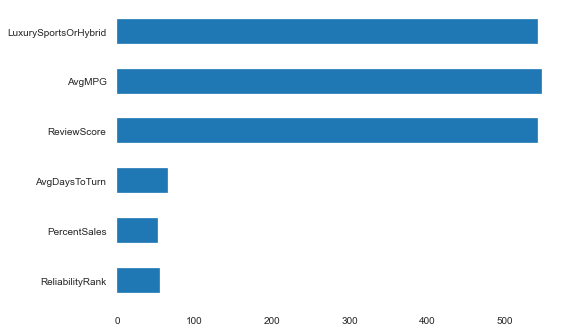

In [13]:
getmissing(df)

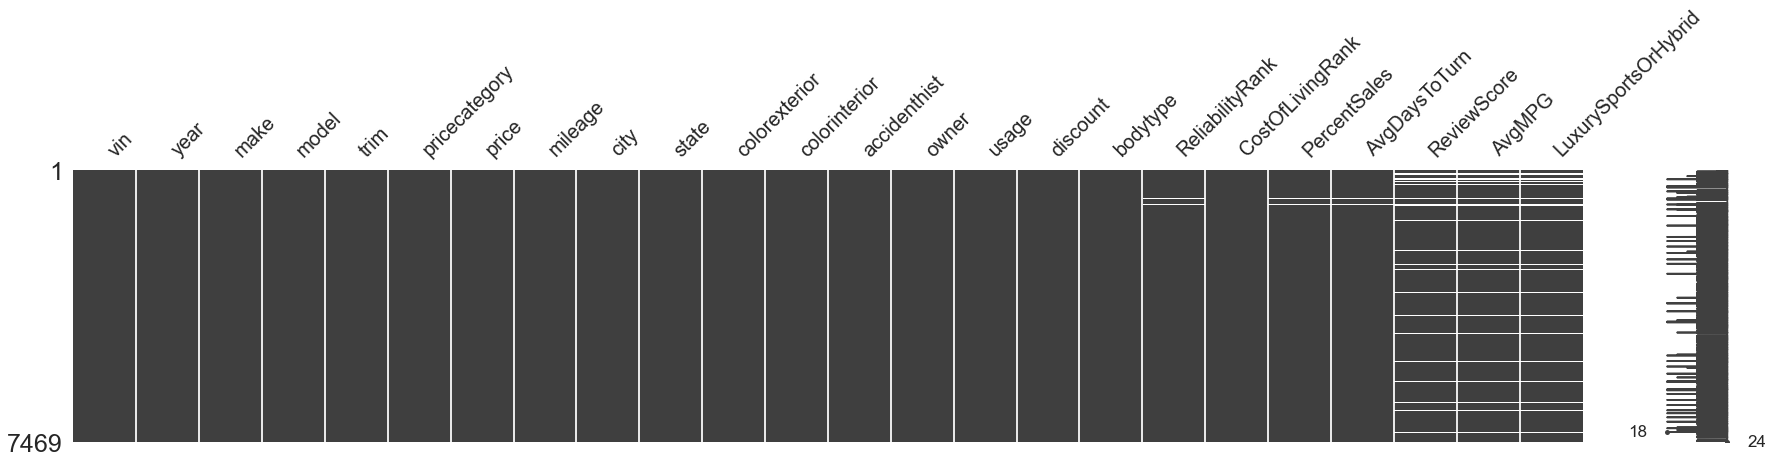

In [14]:
msno.matrix(df,figsize=(30,5), fontsize=20)

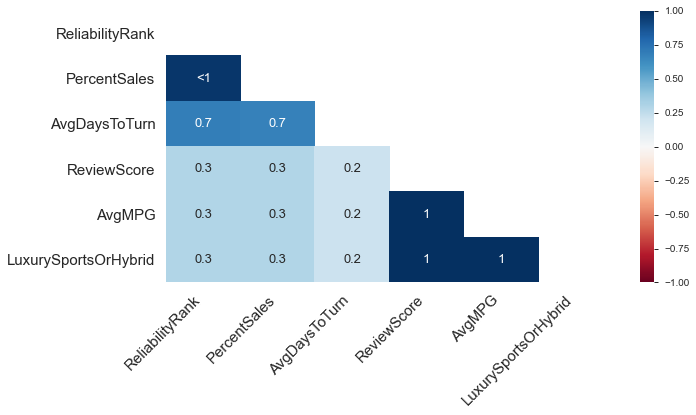

In [15]:
msno.heatmap(df,figsize=(10,5), fontsize=15)

<div class="alert alert-block alert-danger">
    
<br>   
   
#### **OBSERVATION : Missing Values**

    
- The NULL vlues in the columns are not clustered around any specific point, it is evenly distributed.
    
- Columns with Null value show correlations - this is because they are extracted from same or similar datasets from same population sample (reviews for a particular year range or specific makes)
   
<br>    
- (ReliabilityRank,PercentSales,AvgDaysToTurn)  are highly correlated for NULL values as they come from similar data set
<br>
- (ReviewScore, AvgMPG,LuxurySportsOrHybrid)  are perfectly correlated for NULL values as they come from same data set.

<br>
    
_The samples with null values are either from Super Luxury brands or from models older than 2012 which were beyond the scope of the data capture process._
 
#### **ACTION : Imputation of missing values  


| Columns with Missing Values |  Impute Strategy 
| --- |  --- 
| AvgMPG,ReliabilityRank,PercentSales,AvgDaysToTurn,ReviewScore | -1
| LuxurySportsOrHybrid  |  'U'

    
- Add a new columns to indicate absence of data for the above fields as described below:

    
| New Indicator Column | Value determination
| --- |  --- 
| ReviewDataAvailable | 'N' if **any one** of the following columns is NULL, else 'Y'
    
    

   
</div>

### Skew and Outlier analysis


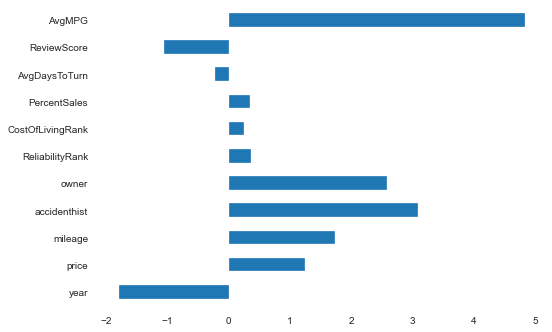

In [16]:
# check Skewness of columns
df.skew().plot(kind = 'barh')

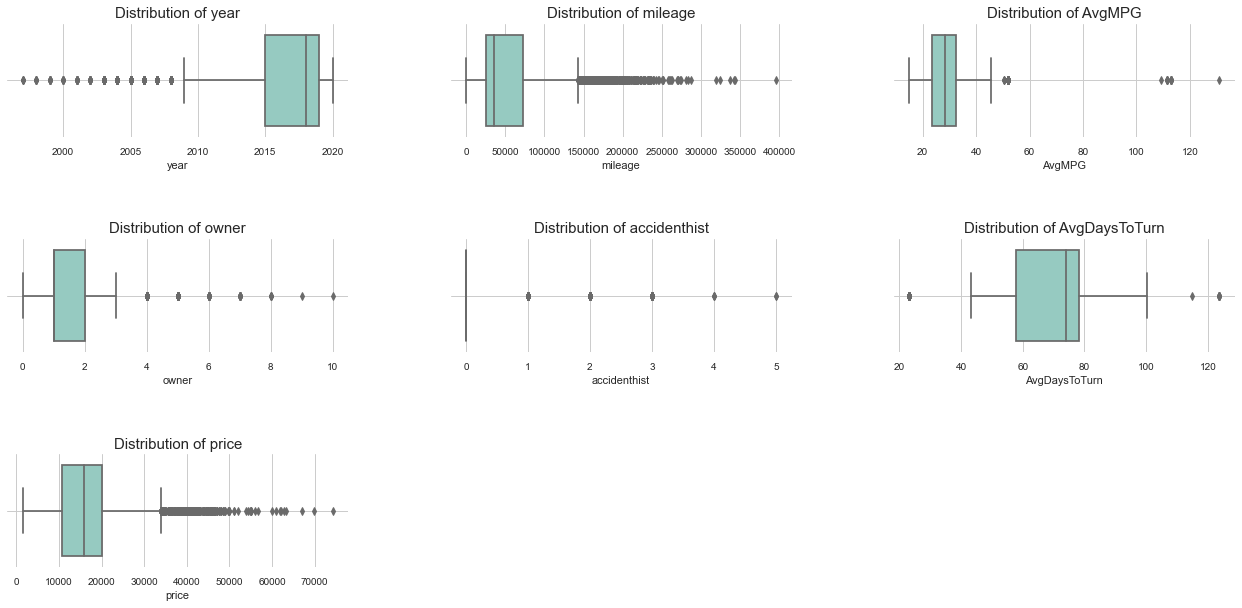

In [17]:
boxplots(df = df, columns = ['year','mileage','AvgMPG','owner','accidenthist','AvgDaysToTurn','price'])

<div class="alert alert-block alert-danger">

#### **OBSERVATION : Skewness**

- Most of the columns have the common/usual values seen in used car data. So these do not really have outliers. 
    
    accidenthist,owner show skewness in the typical values of used cars  <br>
    year shows skewness for 2015 - 2019 which is typical age of listed used cars <br>
    reviewscore has lot of values 6.5 to 8 <br>
    

#### **OBSERVATION : Outliers**

- **Outliers seen for year < 2008** : It is common for used cars listings to have cars older than 10-15 years. 
    
- **Outliers seen for mileage > 150000** : It is common for used cars to have mileage > 150000, but here mileage values > 250000 are observed

- **Outliers seen for AvgMPG > 45** :  Electric/Hybrid/small may have AvgMPG > 45
    
- **Outliers seen for owner > 4** :  It is common for used cars listings to have more than 1 owners
    
- **Outliers seen for accidenthist > 0** :  It is uncommon for used car listings to have more than 2 accidents, No accident is most common

- **Outliers seen for price > 35000** :  Prices beyond 50k is very rare unless for used cars
    
    
#### **ACTION : Creation of Dervied features**
    
Deriving new categorical features will help in reducing the effect of outliers
    
    
</div>

### Missing data handling - imputations, creation of additional attributes 

In [18]:
# Function to clip outliers outside mean +- 2SD
def clipoutliers_2SD(df,columns):
    df2 = df.copy()    
    for col in columns:          
        ulim = df2[col].mean() + 2*df2[col].std()
        llim = df2[col].mean() - 2*df2[col].std()
        df2[col] = df2[col].clip(llim,ulim)
    return df2

In [19]:
# Reduce the number of possible values of a feature
# Either by creating new features or converting them into categorical

# Imputation for columns: 'AvgMPG','ReliabilityRank','PercentSales','AvgDaysToTurn','ReviewScore' set to column median
for col in ['AvgMPG','ReliabilityRank','PercentSales','AvgDaysToTurn','ReviewScore']:
    df[col] = df[col].fillna(df[col].median()) 


# Imputation for 'LuxurySportsOrHybrid', set as 'U' - unknown
df['LuxurySportsOrHybrid'].fillna('U',inplace = True)

   
# extract drivetrain from the trim
# missing data is assigned FWD. 
# FWD and 2WD is mapped to FWD
# AWD, RWD, 4WD are mapped to AWD
df['drivetrain'] = df['trim'].apply(lambda x:[d for d in ['AWD','RWD','FWD','4WD','2WD'] if d in x])
df['drivetrain'] = df['drivetrain'].apply(lambda x:x[0] if len(x) > 0 else 'FWD')
df['drivetrain'] = df['drivetrain'].apply(lambda x:'FWD' if x in ['FWD','2WD'] else 'AWD')    
    
# convert year to age
df['age'] = 2020 - df['year'] 

# convert mileage value to thousands and rename to odo
df['odo'] = df['mileage']/1000 

# Convert to categorical 
# convert owners and accidenthist to 3 groups
df['owner'] = pd.cut(x=df['owner'], bins=[-1,0,1,20], labels=[0,1,2])
df['accidenthist'] = pd.cut(x=df['accidenthist'], bins=[-20,0,20], labels=['N', 'Y'])


# clip outliers to mean +/- 2 SD
df = clipoutliers_2SD(df = df,columns = ['age','odo','AvgMPG','AvgDaysToTurn','price'])

# drop the root columns that were used to derive the categorical columns
df = df.drop(columns = ['year','trim','mileage']) 


In [20]:
sample(df)

,vin,make,model,pricecategory,price,city,state,colorexterior,colorinterior,accidenthist,owner,usage,discount,bodytype,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,LuxurySportsOrHybrid,drivetrain,age,odo
4705,2HKRM3H72EH559848,HONDA,CRV,EXCELLENT PRICE,12730.00,STUART,FL,GRAY,GRAY,N,2,PERSONAL,Y,SUV,18.00,27,8.34,48.69,8.50,29.00,N,FWD,6.00,83.67
9219,KL8CD6SA6HC729889,CHEVROLET,SPARK,EXCELLENT PRICE,7977.00,JOPLIN,MO,WHITE,BLACK,N,1,PERSONAL,Y,HATCHBACK,9.00,6,11.69,78.23,7.60,34.00,N,FWD,3.00,77.43
5871,KNMAT2MT9KP528223,NISSAN,ROGUE,GREAT PRICE,18198.00,VACAVILLE,CA,WHITE,BLACK,N,1,PERSONAL,Y,SUV,16.00,49,6.29,76.23,7.40,29.50,N,FWD,1.00,36.34
5486,3C3CFFDR3CT335398,FIAT,500,NOT LISTED,3999.00,COSTA MESA,CA,SILVER,BEIGE,Y,2,PERSONAL,N,HATCHBACK,27.00,49,0.04,102.24,5.90,30.50,N,FWD,8.00,94.87
2308,WDCTG4GB2JJ418217,MERCEDES-BENZ,GLA,EXCELLENT PRICE,22900.00,AUSTIN,TX,SILVER,BLACK,Y,1,FLEET,N,SUV,22.00,14,2.21,57.92,8.40,19.00,Y,FWD,2.00,24.16


#### POST-IMPUTE AND STANDARDIZATION CHECKS

In [21]:
# Check null value distribution after impute
getmissing(df)

There are no columns with nulls


In [22]:
info(df)

24 columns
object      13
float64     8 
category    1 
int64       1 
category    1 
Name: data type, dtype: int64


,unique values,nullvalues,data type
vin,7469,0,object
make,44,0,object
model,373,0,object
pricecategory,4,0,object
price,3344,0,float64
city,1322,0,object
state,50,0,object
colorexterior,17,0,object
colorinterior,9,0,object
accidenthist,2,0,category


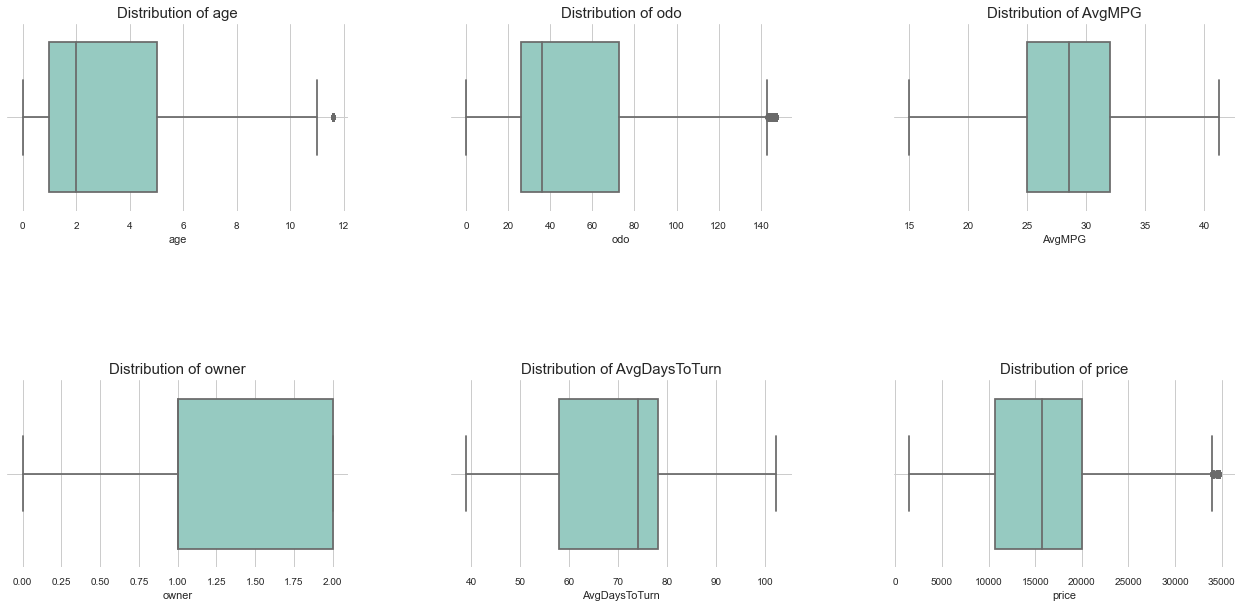

In [23]:
boxplots(df = df, columns = ['age','odo','AvgMPG','owner','AvgDaysToTurn','price'])

<div class="alert alert-block alert-success">
    
### Results and Observations for Step 2 - Handling missing data and outliers:

1. All missing data were imputed based on the logic described above.
    
2. Outliers have been detected and removed to mean +/- 2SD. 
    
3. Derived columns have been created from  the columns having outliers and original columns have been removed.
    
</div>


## <span style="color:Blue"> Step 3: Explore relationships </span>

#### Get a subset of the most listed make models

In [24]:
df1 = df.copy()
df1['makemodel'] = df1['make'].astype(str) + ' ' +  df1['model'].astype(str)
df1 = df1[['makemodel','pricecategory', 'price','state','CostOfLivingRank','colorexterior', 'colorinterior', 'accidenthist', 'owner', 'usage','discount','age','odo']]
df1.loc[:,'odo'] = df1.loc[:,'odo'].apply(lambda x:round(x,0))
df1.loc[:,'price'] = df1.loc[:,'price'].apply(lambda x:round(x/100,2))
df1.groupby(['makemodel']).size().reset_index(name='count').sort_values(['count'], ascending = False).head(10)

,makemodel,count
165,HYUNDAI ELANTRA,391
298,NISSAN ROGUE,360
107,DODGE GRAND CARAVAN,355
301,NISSAN SENTRA,337
133,FORD FUSION,315
340,TOYOTA CAMRY,269
284,NISSAN ALTIMA,245
342,TOYOTA COROLLA,238
154,HONDA CIVIC,222
153,HONDA ACCORD,211


#### Filter data for the three most common make model

In [25]:
df1 = df1[(df1['makemodel'].isin(['HYUNDAI ELANTRA','NISSAN ROGUE','NISSAN SENTRA']))]

#### Plot Odometer vs Price : age/owner/accidenthist constant
_Negative correlation observed between odometer and price_

_price cateogories dont show any specific relationships_

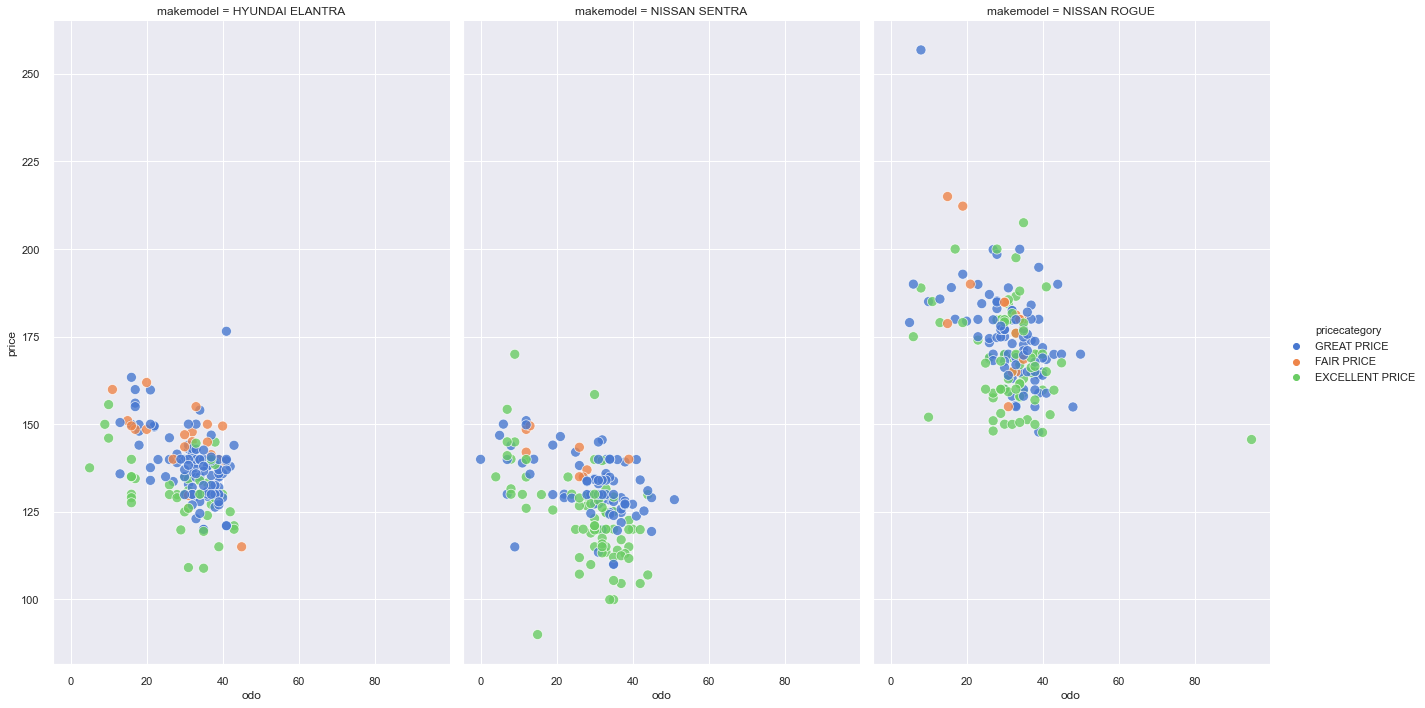

In [26]:
sns.set(style="darkgrid")
sns.relplot(x = 'odo', y = 'price', 
                hue='pricecategory', 
                alpha=.8, 
                palette="muted", 
                height=10,
                aspect=0.6,
                col = 'makemodel',
                s=100,
                data=df1[(df1['owner'] == 1) & (df1['age'] == 1) & (df1['accidenthist'] == 'N')]) 


#### Plot CostOfLivingRank  vs Price : odometer/owner/age constant
_No correlation observed between CostOfLivingRank and price_

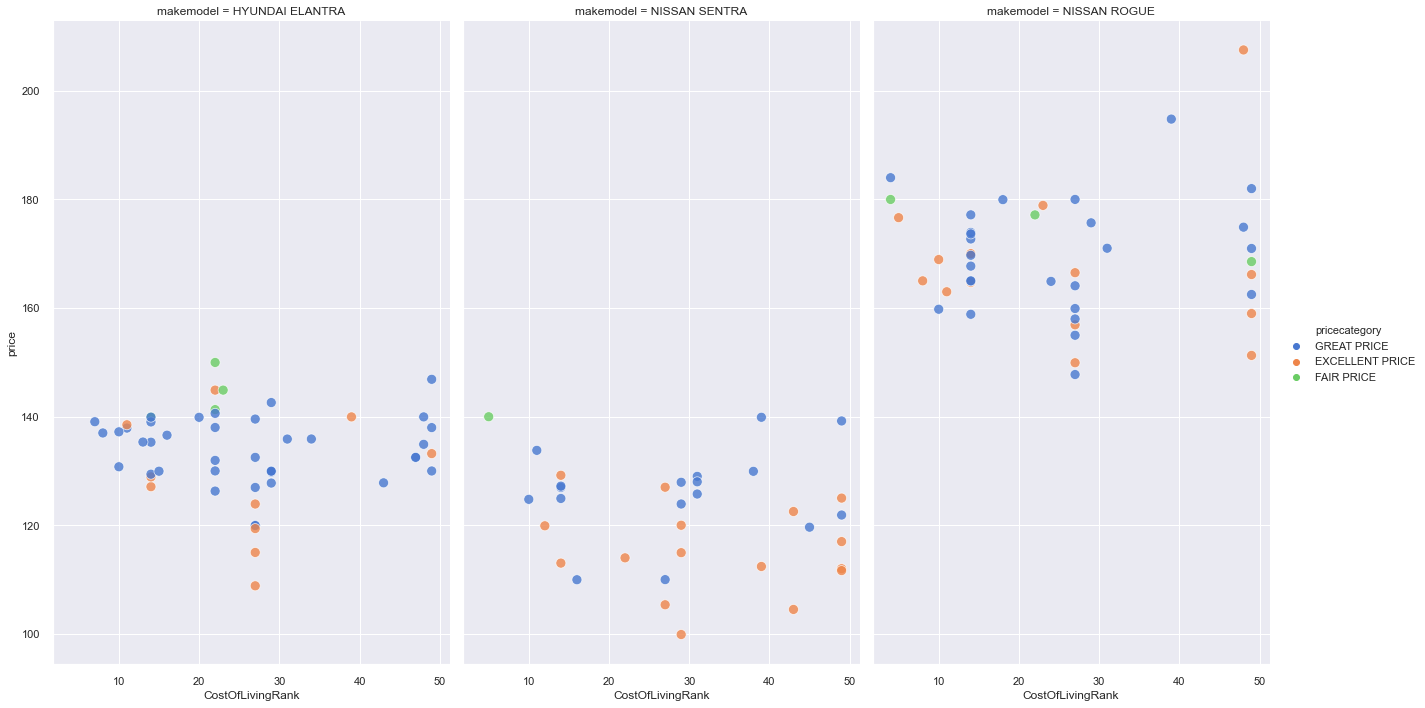

In [27]:
sns.set(style="darkgrid")
sns.relplot(x = 'CostOfLivingRank', y = 'price', 
                hue='pricecategory', 
                alpha=.8, 
                palette="muted", 
                height=10,
                aspect=0.6,
                col = 'makemodel',
                s=100,
                data=df1[(df1['odo'].between(35,39)) & (df1['owner'] == 1) & (df1['age'] == 1) & (df1['accidenthist'] == 'N')]) 


#### Plot Age  vs Price : odometer/owner constant
_Negative correlation observed between age and price_

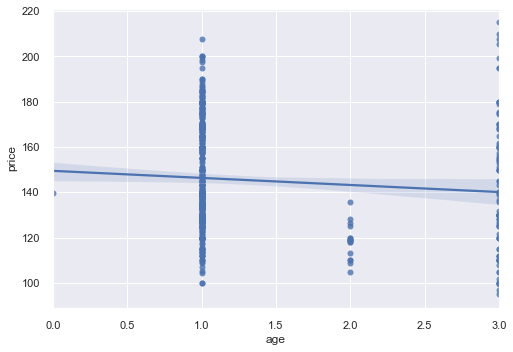

In [28]:
sns.set(style="darkgrid")
sns.regplot(x = 'age', y = 'price', 
               
                data=df1[(df1['odo'].between(20,39)) & (df1['owner'] == 1) & (df1['accidenthist'] == 'N')]) 


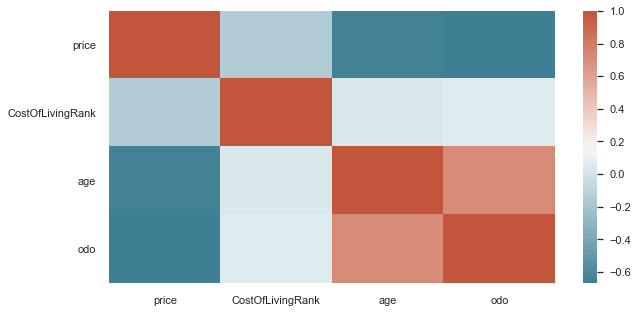

In [29]:
# plot the correlation heatmap for all columns
corr = df1.corr()
plt.figure(figsize = (10,5))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=False, cmap=sns.diverging_palette(220, 20, as_cmap=True))

### Checking potential one-hot features 
- if the number of unique values can be grouped for optimal one-hot encoding

The following features need to be one-hot encoded as simple numeric encoding can make the model interpret them numerically for a regression problem.

    FEATURE     UNIQUE_VALUES
    colorexterior	       17 
    bodytype	           11
    colorinterior	       10	 
    accidenthist	        2	 
    owner	                3	 
    usage	                2	 
    drivetrain	            2	
    LuxurySportsOrHybrid	3
    
If we one-hot all of them, it gives 50 features.

For the features having less than 5 distinct values, we can do one-hot for all possible values. 

However, for features with more than 10 unique values, we need to check the possibility of reducing the number of values.

Generally, we will group less frequently values into a separate category like 'OTHER'

In [30]:
df.groupby(['colorexterior']).size().sort_values(ascending = False)

colorexterior
WHITE      2163
BLACK      1720
SILVER     1393
GRAY       1136
BLUE       454 
RED        441 
UNKNOWN    47  
GOLD       39  
BROWN      25  
TAN        20  
GREEN      15  
PURPLE     4   
YELLOW     3   
BEIGE      3   
MAROON     3   
ORANGE     2   
TEAL       1   
dtype: int64

In [31]:
df['colorexterior'] = df['colorexterior'].apply(lambda x: x if x in ['WHITE', 'BLACK', 'SILVER', 'GRAY', 'BLUE', 'RED'] else 'OTHER')

In [32]:
df.groupby(['colorinterior']).size().sort_values(ascending = False)

colorinterior
BLACK      4556
GRAY       1449
UNKNOWN    799 
BEIGE      514 
BROWN      84  
RED        47  
BLUE       10  
WHITE      9   
GREEN      1   
dtype: int64

In [33]:
df['colorinterior'] = df['colorinterior'].apply(lambda x: x if x in ['BLACK', 'GRAY', 'BEIGE'] else 'OTHER')

In [34]:
df.loc[df['bodytype'] == 'SUV1992','bodytype'] = 'SUV'
df.loc[df['bodytype'] == 'SEDAN ','bodytype'] = 'SEDAN'
df.groupby(['bodytype']).size().sort_values(ascending = False)

bodytype
SEDAN          3842
SUV            2150
VAN/MINIVAN    562 
PICKUP         460 
WAGON          170 
COUPE          144 
HATCHBACK      103 
CONVERTIBLE    26  
TRUCK          12  
dtype: int64

In [35]:
info(df[['colorexterior','colorinterior','bodytype']])

3 columns
object    3
Name: data type, dtype: int64


,unique values,nullvalues,data type
colorexterior,7,0,object
colorinterior,4,0,object
bodytype,9,0,object


After the modification, the total number of unique values is reduced to 22. SO there would be 22 one hot features needed.

## <span style="color:Blue"> Step 4: Encode Data </span>

In [36]:
# drop unwanted columns 
df2 = df.copy()
df2 = df2.drop(columns = ['vin', 'city', 'state','make','model','discount','pricecategory'])
# create onehot for the columns with low cardinality
dum_cols = ['owner', 'usage','LuxurySportsOrHybrid','drivetrain','accidenthist','colorexterior','colorinterior','bodytype']
df2 = pd.get_dummies(df2, columns = dum_cols)

In [37]:
info(df2)

41 columns
uint8      32
float64    8 
int64      1 
Name: data type, dtype: int64


,unique values,nullvalues,data type
price,3344,0,float64
ReliabilityRank,31,0,float64
CostOfLivingRank,50,0,int64
PercentSales,33,0,float64
AvgDaysToTurn,29,0,float64
ReviewScore,32,0,float64
AvgMPG,41,0,float64
age,13,0,float64
odo,6664,0,float64
owner_0,2,0,uint8


In [38]:
# # create a custom Encoder class to handle new unseen values as UNKNOWN 
# # this is an extension of the sklearn Label Encoder class
# class MyLabelEncoder():
    
#     # initialize encoder with base constructor of LabelEncoder
#     def __init__(self):
#         self.encoder = LabelEncoder()

#     def fit(self, values):
#         # add a category "UNKNOWN"
#         # this will be used as the category when an "unseen" value shows up in the data set
#         self.encoder = self.encoder.fit(list(values) + ['UNKNOWN'])
#         self.classes_ = self.encoder.classes_

#     def transform(self,values):

#         values = list(values)
#         # for each item in new values
#         for item in np.unique(values):
#             # if the item is not in the encoder classes (new unseen value   ) mark it as 'UNKNOWN'
#             if item not in self.classes_:
#                 values = ['UNKNOWN' if x == item else x for x in values]

#         return self.encoder.transform(values)

# # Function to build encoder list for columns which are non-numeric
# # Generate a dictionary of encoders to be used for test set
# def generate_label_encoders(df):

#     encdict = {}

#     for col in df.select_dtypes(include = ['object']).columns:
#         enc = MyLabelEncoder()
#         enc.fit(df[col])
#         encdict.update({col : enc})

#     return encdict 


# # Encode the data using the passed in encoders

# def encode_data(df,encoders):

#     df1 = df.copy()

#     for col in df1.select_dtypes(include = ['object']).columns:
#         df1[col]  = encoders[col].transform(df1[col])

#     return df1

In [39]:
#encoders = generate_label_encoders(df2)

In [40]:
#df2 = encode_data(df2,encoders)

In [41]:
#sample(df2)

In [42]:
#info(df2)

In [43]:
# Ensure No Nulls
assert df2.isnull().sum().sum() == 0

In [45]:
# Ensure No Non-Numeric
assert len(df2.select_dtypes(exclude = ['int64','float64','uint8']).columns) == 0 

<div class="alert alert-block alert-success">

### RESULT:  Data Encoding -  ALL NUMERIC , NO NULLS
    
- all categorical columns have been label encoded to numeric
- no non-numeric columns are present in the data set
- no null values are present in the data set
    
</div>

## <span style="color:Blue"> Step 5: Prepare feature vectors and execute Train-Test Split in 80/20 ratio </span>

In [46]:
# Get dependent and independent variables in arrays

# X is all columns except price
X = df2.loc[:,~df2.columns.isin(['price']) ]
# X labels would be used to identify feature importances
X_labels = df2.columns[~df2.columns.isin(['price'])]
y = df2['price']

# Train and Test for target variable "price"
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=0)


In [47]:
print(f'Sizes of sets : X_train = {X_train.shape}  y_train = {y_train.shape}  X_test = {X_test.shape}   y_test = {y_test.shape} ')

Sizes of sets : X_train = (5975, 40)  y_train = (5975,)  X_test = (1494, 40)   y_test = (1494,) 


## <span style="color:Blue"> Step 6: Explore models invididually to get initial idea </span>
### <span style="color:Red"> Explore the feature importances indicated by the Random Forest Regressor and XG Boost Regressor  </span>



### Using RandomizedSearchCV with RandomForest

In [48]:
'''
Hyperparamter reference for Random Forest:

n_estimators : number of decision trees in the forest
max_features: number of features to select (auto/sqrt/log)
max_depth : The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
min_samples_split : The minimum number of samples required to split an internal node
min_samples_leaf : The minimum number of samples required to be at a leaf node

'''   

# Create Randomized Search params
max_depth = [int(x) for x in np.linspace(10, 50,num = 9)]
max_features = ['auto', 'sqrt']
max_depth.append(None)
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Create the Randomized Search Grid
param_grid = {  'max_depth': max_depth,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'n_estimators': n_estimators
              }


# create the base model to tune
rf = RandomForestRegressor(random_state=1)

# Ramdomized CV search of parameters, using 3 fold cross validation for 100 iterations 
rf_random = RandomizedSearchCV(estimator = rf, 
                            param_distributions = param_grid, 
                            random_state=1,
                            n_iter = 200,
                            cv = 3, 
                            n_jobs = -1, 
                            verbose = 2)


# Fit the grid search search model
rf_random.fit(X_train, y_train)



print("\nRESULTS: RandomizedSearchCV for the Random Forest Regressor")
print("\n===================================")
print("\n Best Params : {} ".format(rf_random.best_params_))
print("\n Best Score : {} ".format(rf_random.best_score_))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 19.5min finished



RESULTS: RandomizedSearchCV for the Random Forest Regressor


 Best Params : {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 15} 

 Best Score : 0.9149821568750885 


### Using RandomizedSearchCV with XGBoost

In [49]:
'''
Hyperparameters : XGBoost

n_estimators : number of decision trees in the forest
min_child_weight: Minimum sum of instance weight(hessian) needed in a child
gamma : Minimum loss reduction required to make a further partition on a leaf node of the tree
colsample_bytree : Subsample ratio of columns when constructing each tree
max_depth : The maximum depth of the tree.
''' 

# Create Randomized Search params

max_depth = [int(x) for x in np.linspace(10, 50,num = 9)]
min_child_weight =  [int(x) for x in np.linspace(1, 10,num = 9)]
gamma = [x for x in np.linspace(0.5,2.0,num = 16)]
colsample_bytree =  [x for x in np.linspace(0.5,1.0,num = 6)]
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Create the Randomized Search Grid
param_grid = {  'max_depth': max_depth,
                'min_child_weight': min_child_weight,
                'gamma': gamma,
                'colsample_bytree': colsample_bytree,
                'n_estimators': n_estimators
              }


# create the base model to tune
xg = XGBRegressor()

# Ramdomized CV search of parameters, using 3 fold cross validation for 100 iterations 
xg_random = RandomizedSearchCV(estimator = xg, 
                            param_distributions = param_grid, 
                            random_state=1,
                            n_iter = 200,
                            cv = 3, 
                            n_jobs = -1, 
                            verbose = 2)


# Fit the grid search search model
xg_random.fit(X_train, y_train)



print("\nRESULTS: RandomizedSearchCV for the XGBoost Regressor")
print("\n=======================================================")
print("\n Best Params : {} ".format(xg_random.best_params_))
print("\n Best Score : {} ".format(xg_random.best_score_))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 70.6min finished



RESULTS: RandomizedSearchCV for the XGBoost Regressor


 Best Params : {'n_estimators': 1800, 'min_child_weight': 10, 'max_depth': 40, 'gamma': 0.7, 'colsample_bytree': 0.7} 

 Best Score : 0.9130785091385752 


### Train individual models on the best parameters obtained in RandomSearchCV

In [50]:
'''
Use the best parameters obtained in the Random Search CV 
Check feature importance for each model 


RandomSearchCV results above:

Best params for RandomForestRegressor --> 
{'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 15} 

Best params for XGBoostRegressor --> 
{'n_estimators': 1800, 'min_child_weight': 10, 'max_depth': 40, 'gamma': 0.7, 'colsample_bytree': 0.7} 

'''

# Check Random Forest Regressor with above parameters
rf_price = RandomForestRegressor(random_state=1, 
                                 n_estimators = 1400, 
                                 max_depth = 15,
                                 max_features = 'auto',
                                 min_samples_leaf = 1,
                                 min_samples_split = 2)

rf_price.fit(X_train, y_train)

rf_pred_price = rf_price.predict(X_test)

print("\nRESULTS FOR RANDOM FOREST REGRESSOR")
print("\n===================================")
print("\nMean Absolute Error (Random Forest): {}".format(round(mean_absolute_error(y_test, rf_pred_price))))
print("\nModel Score (Random Forest): {}".format(rf_price.score(X_test,y_test)))
print("\nModel Params (Random Forest): {}".format(rf_price.get_params()))

##############################################################################

# Create an XGB Regressor
xg_price = XGBRegressor(colsample_bytree = 0.7, 
                        gamma = 0.7,
                        max_depth = 40, 
                        min_child_weight = 10, 
                        n_estimators = 1800)

xg_price.fit(X_train, y_train)

xg_pred_price = xg_price.predict(X_test)

print("\nRESULTS FOR XG BOOST REGRESSOR")
print("\n===================================")
print("\nMean Absolute Error (XGBoost): {}".format(round(mean_absolute_error(y_test, xg_pred_price))))
print("\nModel Score (XGBoost): {}".format(xg_price.score(X_test,y_test)))
print("\nModel Params (XGBoost): {}".format(xg_price.get_params()))



RESULTS FOR RANDOM FOREST REGRESSOR


Mean Absolute Error (Random Forest): 1430.0

Model Score (Random Forest): 0.9265543456074575

Model Params (Random Forest): {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1400, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}

RESULTS FOR XG BOOST REGRESSOR


Mean Absolute Error (XGBoost): 1516.0

Model Score (XGBoost): 0.9225007892981938

Model Params (XGBoost): {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7, 'gamma': 0.7, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 40, 'mi

### Feature importance from Random Forest 

In [51]:
# Feature importance for Random Forest - list of columns
rf_feat_imp = pd.DataFrame(rf_price.feature_importances_,
                           index = X_labels,
                           columns = ['Importance_Score_RF']
                           )
rf_feat_imp.sort_values('Importance_Score_RF', ascending = False)

,Importance_Score_RF
odo,0.31
AvgMPG,0.30
age,0.15
LuxurySportsOrHybrid_N,0.05
ReviewScore,0.04
PercentSales,0.02
AvgDaysToTurn,0.02
bodytype_PICKUP,0.02
LuxurySportsOrHybrid_Y,0.02
ReliabilityRank,0.01


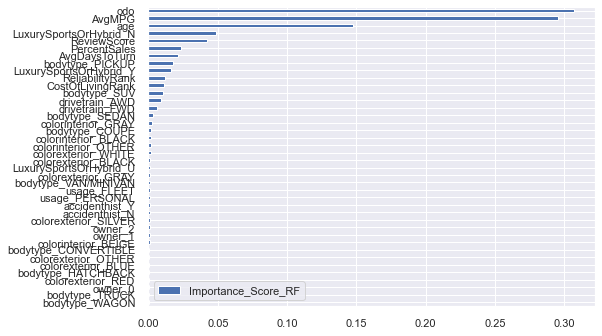

In [53]:
# Graph Representation of Importance Scores for Random Forest
rf_feat_imp.sort_values('Importance_Score_RF', ascending = True).plot(kind = 'barh')

### Feature importance from XGBoost

In [52]:
# Feature importance for XG Boost - list of columns
scores = xg_price.get_booster().get_score()
xg_feat_imp = pd.DataFrame.from_dict(scores, orient ='index', columns = ['Importance_Score_XG'])
xg_feat_imp.sort_values('Importance_Score_XG', ascending = False)

,Importance_Score_XG
odo,72524
CostOfLivingRank,24210
AvgMPG,11577
ReviewScore,10684
age,8868
ReliabilityRank,7439
PercentSales,6647
AvgDaysToTurn,6583
colorexterior_WHITE,3962
colorinterior_BLACK,3154


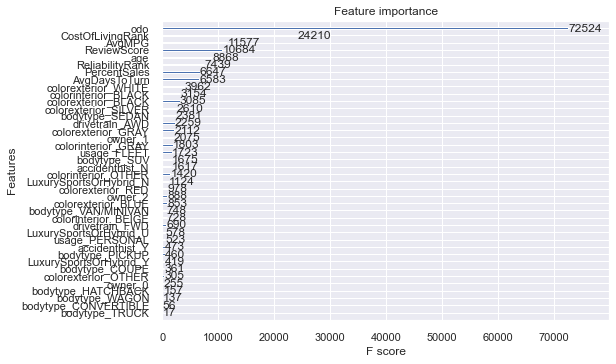

In [54]:
# Graph Representation of Importance Scores for XG Boost
plot_importance(xg_price)

<div class="alert alert-block alert-success">
    
## Results and Observations for Step 6  - Feature Importance

Both the models show around 91% score with MAE = 1440.

Top features combining both models are:
    


    

</div>


## <span style="color:Blue"> Step 7: Combine models by Stacking along with Grid Search  </span>

- The two models are stacked with StackingRegressor and GridSearchCV is used to find best hyperparameters.

- Meta regressor used = XGBoost Regressor


In [ ]:
'''
Best params for RandomForestRegressor --> 
{'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 15} 

Best params for XGBoostRegressor --> 
{'n_estimators': 1800, 'min_child_weight': 10, 'max_depth': 40, 'gamma': 0.7, 'colsample_bytree': 0.7} 
'''


from mlxtend.regressor import StackingRegressor

#Initializing base estimators
xg = XGBRegressor()
rf = RandomForestRegressor(random_state=1)

#Initializing meta regressor
xg_meta = XGBRegressor()

#Stacking the various regressors initialized before
stack = StackingRegressor(regressors = [xg, rf],
                          meta_regressor = xg_meta)

# Define grid search params
params = {  'randomforestregressor__max_depth': [15,20],
            'randomforestregressor__n_estimators': [1400,1600],
            'xgbregressor__gamma': [0.7,0.9],
            'xgbregressor__max_depth':  [40,50],
            'xgbregressor__n_estimators': [1800,2000],
            'meta_regressor__gamma': [0.7,0.8],
            'meta_regressor__max_depth':  [20,30],
            'meta_regressor__n_estimators': [1400,1600]
        }



# Check the parameters for Stacking Regressor. Need to use only those names.

grid = GridSearchCV(
                    estimator=stack, 
                    param_grid=params, 
                    cv=3,
                    verbose = 2,
                    n_jobs = -1,
                    refit=True
                    )

#Fitting the data
grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))


Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 78.6min


### Check parameter tuning results - scores and parameters every 100th iteration

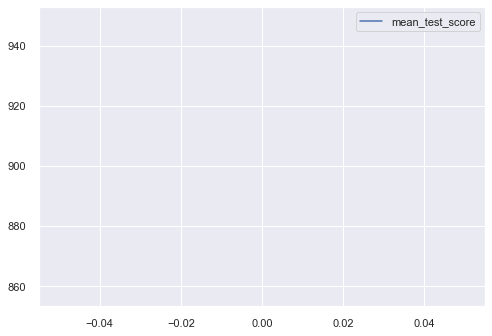

In [57]:
test_scores = grid.cv_results_['mean_test_score'] * 1000
df_stack_test_scores = pd.DataFrame(test_scores, columns=["mean_test_score"])
df_stack_test_scores[df_stack_test_scores.index%100 == 0].plot()

# the score oscillates between 0.900 and 0.912

In [61]:
cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    if r%10 == 0: 
        print("%0.3f +/- %0.2f %r"
              % (grid.cv_results_[cv_keys[0]][r],
                 grid.cv_results_[cv_keys[1]][r] / 2.0,
                 grid.cv_results_[cv_keys[2]][r]))
    

0.903 +/- 0.00 {'meta_regressor__gamma': 0.5, 'meta_regressor__max_depth': 10, 'meta_regressor__n_estimators': 1000, 'randomforestregressor__max_depth': 10, 'randomforestregressor__n_estimators': 1500, 'xgbregressor__gamma': 0.5, 'xgbregressor__max_depth': 30, 'xgbregressor__n_estimators': 2000}
0.903 +/- 0.00 {'meta_regressor__gamma': 0.5, 'meta_regressor__max_depth': 10, 'meta_regressor__n_estimators': 1000, 'randomforestregressor__max_depth': 20, 'randomforestregressor__n_estimators': 1500, 'xgbregressor__gamma': 1, 'xgbregressor__max_depth': 30, 'xgbregressor__n_estimators': 2000}
0.903 +/- 0.00 {'meta_regressor__gamma': 0.5, 'meta_regressor__max_depth': 10, 'meta_regressor__n_estimators': 1500, 'randomforestregressor__max_depth': 20, 'randomforestregressor__n_estimators': 1500, 'xgbregressor__gamma': 0.75, 'xgbregressor__max_depth': 30, 'xgbregressor__n_estimators': 2000}
0.903 +/- 0.00 {'meta_regressor__gamma': 0.5, 'meta_regressor__max_depth': 20, 'meta_regressor__n_estimators':

### Train the stacking regressor on the best params obtained in Grid Search

In [ ]:
stack.set_params(**best_params)

In [ ]:
stack.fit(X_train, y_train)

### Test prediction on the Test Set on the stacked regressor trained with best params

In [ ]:
y_stack_pred = stack.predict(X_test)

In [ ]:
# Evaluate and visualize the fit

print("Mean Squared Error: %.4f" % np.mean((y_stack_pred - y_test) ** 2))
print("Score: %.4f" % stack.score(X_test, y_test))


## <span style="color:Blue"> Step 8 -  Save the Stacking Regressor into Pickle file  </span>

- Save the stacked regressor into a pickle file

- Test the pickled model file by loading it and invoking predict on the hold out set 

In [ ]:
import pickle 
# Save the stacking regressor

model_pkl_file = "carprice_stack_model_v1.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(stack, file)



## <span style="color:Blue"> Step 9 -  Test the model with new data (from holdout set)  </span>

- Get the model from the pickle dump 

- Get holdout dataset and convert data as per model inputs

- Call predict and check score

### Test Stacking Regressor on holdout set by getting from pickle file

In [ ]:
# Load from file
model_pkl_file = "carprice_stack_model_v1.pkl"

with open(model_pkl_file, 'rb') as file:
    stack_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = stack_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))

In [ ]:
## Params obtained with XG + RF on SVR as meta regressor.
## SVR performed very poorly as meta regressor giving negative score


# best_params = grid.best_params_
# best_params

# Fitting 3 folds for each of 1458 candidates, totalling 4374 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
# [Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.4min
# [Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 19.5min
# [Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 38.0min
# [Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 60.2min
# [Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 89.7min
# [Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 122.0min
# [Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 158.8min
# [Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 202.0min
# [Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 250.1min
# [Parallel(n_jobs=-1)]: Done 4374 out of 4374 | elapsed: 273.7min finished
# Best: -0.006848 using {'meta_regressor__C': 10.0, 'meta_regressor__gamma': 0.1, 'randomforestregressor__max_depth': 40, 'randomforestregressor__n_estimators': 700, 'xgbregressor__gamma': 1.5, 'xgbregressor__max_depth': 15, 'xgbregressor__n_estimators': 500}
    
    
# {'meta_regressor__C': 10.0,
#  'meta_regressor__gamma': 0.1,
#  'randomforestregressor__max_depth': 40,
#  'randomforestregressor__n_estimators': 700,
#  'xgbregressor__gamma': 1.5,
#  'xgbregressor__max_depth': 15,
#  'xgbregressor__n_estimators': 500}    
    

In [ ]:
#df.to_csv('Used_Car_TrainTest_Set_final.csv',encoding = "ISO-8859-1",index=False)

In [ ]:
#df_hold.to_csv('Used_Car_HoldOut_Set_final.csv',encoding = "ISO-8859-1",index=False)